<a href="https://colab.research.google.com/github/nityamshah/datascience/blob/main/unit7/NityShahU7proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

In [ ]:
!pip install git+https://github.com/pydata/xarray.git
import xarray as xr
!pip install bambi
import bambi as bmb

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-sg1fqepk
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-sg1fqepk
  Resolved https://github.com/pydata/xarray.git to commit 0184702f16c3f744fc9096c7dac690626dcc6922
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached bambi-0.15.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached formulae-0.5.4-py3-none-any.whl.metadata (4.5 kB)
Using cached bambi-0.15.0-py3-none-any.whl (109 kB)
Using cached formulae-0.5.4-py3-none-any.whl (53 kB)


Want to predict how much muscle mass (LBM) changes in response to different factors, particularly protein intake, exercise type, and duration. Maybe accounting for factors like BMI or Age.

In [ ]:
#load the data into a pandas dataframe
#got this data from kaggle: https://www.kaggle.com/datasets/fgloblek/protein-intake-and-muscle-mass-data-pmc7727026
url = 'https://raw.githubusercontent.com/nityamshah/datascience/main/data/PMC7727026_abbreviated.csv'
data = pd.read_csv(url)
data

,Author and Year,Group,Study Weight Percentage,Percent male (%),Race with largest number,Age (years),Height (cm),Weight (kg),BMI (kg/m2),Health state,Duration (weeks),Type ofExercise,(times/week),Energy balance,Protein intake (g/kg/day),Energy intake (kcal/kg/day),LBM change (kg),LBM change per week (kg/wk),Relative LBM change,Relative LBM change per week
0,Campbell (1995) [1],Experimental,0.3,83,Caucasian,65.0,173.3,78.0,26.0,Healthy,12,Resistance exercise,3,No intervention,2.40,37.00,1.80,0.150000,0.023077,0.001923
1,Rozenek (2002) [2],Experimental,0.5,100,Caucasian,23.2,178.3,76.4,24.1,Healthy,8,Resistance exercise,4,Intake > Expenditure,3.30,63.30,2.90,0.362500,0.037958,0.004745
2,Flakoll (2004) [3],Experimental,0.9,100,Caucasian,18.9,177.0,74.9,23.4,Healthy,8,Resistance exercise & other exercise,4,No intervention,NaN,NaN,-2.70,-0.337500,-0.036048,-0.004506
3,Rankin (2004) [4],Experimental,0.6,100,Caucasian,20.8,177.5,78.9,25.1,Healthy,10,Resistance exercise,3,No intervention,1.25,33.30,1.60,0.160000,0.020279,0.002028
4,Layman (2005) (with RT) [5],Experimental,1.0,0,Caucasian,46.7,163.2,87.7,33.0,Healthy,17,Resistance exercise & other exercise,2,Intake < Expenditure,NaN,NaN,-0.40,-0.023529,-0.004561,-0.000268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,Fernandes (2018) [49],Control,1.1,0,Others,67.6,155.8,62.3,25.7,Healthy,12,Resistance exercise,3,No intervention,0.87,26.70,0.70,0.058333,0.011236,0.000936
108,Galbreath (2018) [50],Control,1.0,0,Caucasian,64.4,161.5,80.1,30.8,Healthy,10,Resistance exercise,3,Intake < Expenditure,1.47,21.76,0.24,0.024000,0.002996,0.000300
109,Sharp (2018) (Beef) [51],Control,0.3,45,Caucasian,20.8,170.2,73.1,25.2,Healthy,8,Resistance exercise,3,Intake = Expenditure,1.54,32.76,1.00,0.125000,0.013680,0.001710
110,Vangsoe (2018) [52],Control,0.7,100,Caucasian,24.2,186.6,79.9,22.9,Healthy,8,Resistance exercise,4,No intervention,1.70,43.20,2.25,0.281250,0.028160,0.003520


In [ ]:
nan_count = data['Protein intake (g/kg/day)'].isna().sum()
print(f"Number of NaN values in 'Protein intake (g/kg/day)': {nan_count}")
nan_count = data['Energy intake (kcal/kg/day)'].isna().sum()
print(f"Number of NaN values in 'Energy intake (kcal/kg/day)': {nan_count}")

Number of NaN values in 'Protein intake (g/kg/day)': 17
Number of NaN values in 'Energy intake (kcal/kg/day)': 19


In [ ]:
#Removing all NaN values in Protein intake and Energy intake columns
data_cleaned = data.dropna(subset=['Protein intake (g/kg/day)', 'Energy intake (kcal/kg/day)'])
data_cleaned

,Author and Year,Group,Study Weight Percentage,Percent male (%),Race with largest number,Age (years),Height (cm),Weight (kg),BMI (kg/m2),Health state,Duration (weeks),Type ofExercise,(times/week),Energy balance,Protein intake (g/kg/day),Energy intake (kcal/kg/day),LBM change (kg),LBM change per week (kg/wk),Relative LBM change,Relative LBM change per week
0,Campbell (1995) [1],Experimental,0.3,83,Caucasian,65.0,173.3,78.0,26.0,Healthy,12,Resistance exercise,3,No intervention,2.40,37.00,1.80,0.150000,0.023077,0.001923
1,Rozenek (2002) [2],Experimental,0.5,100,Caucasian,23.2,178.3,76.4,24.1,Healthy,8,Resistance exercise,4,Intake > Expenditure,3.30,63.30,2.90,0.362500,0.037958,0.004745
3,Rankin (2004) [4],Experimental,0.6,100,Caucasian,20.8,177.5,78.9,25.1,Healthy,10,Resistance exercise,3,No intervention,1.25,33.30,1.60,0.160000,0.020279,0.002028
5,Candow (2006) (Post) [6],Experimental,0.4,100,Caucasian,64.8,174.0,86.7,28.6,Healthy,12,Resistance exercise,3,No intervention,1.26,28.80,0.94,0.078333,0.010842,0.000903
6,Candow (2006) (Pre) [6],Experimental,0.4,100,Caucasian,64.8,174.0,86.7,28.6,Healthy,12,Resistance exercise,3,No intervention,1.40,26.60,0.71,0.059167,0.008189,0.000682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,Verreijen (2017) (with RT) [48],Control,0.8,41,Caucasian,62.5,169.3,92.5,32.3,Healthy,10,Resistance exercise,3,Intake < Expenditure,1.64,21.40,0.20,0.020000,0.002162,0.000216
107,Fernandes (2018) [49],Control,1.1,0,Others,67.6,155.8,62.3,25.7,Healthy,12,Resistance exercise,3,No intervention,0.87,26.70,0.70,0.058333,0.011236,0.000936
108,Galbreath (2018) [50],Control,1.0,0,Caucasian,64.4,161.5,80.1,30.8,Healthy,10,Resistance exercise,3,Intake < Expenditure,1.47,21.76,0.24,0.024000,0.002996,0.000300
109,Sharp (2018) (Beef) [51],Control,0.3,45,Caucasian,20.8,170.2,73.1,25.2,Healthy,8,Resistance exercise,3,Intake = Expenditure,1.54,32.76,1.00,0.125000,0.013680,0.001710


In [ ]:
new_column_names = {
    'Protein intake (g/kg/day)': 'protein_intake',
    'Energy intake (kcal/kg/day)': 'energy_intake',
    'Relative LBM change per week': 'relative_lbm_change_week',
    'Age (years)' : 'age',
    'BMI (kg/m2)' : 'bmi',
    '(times/week)' : 'freq',
    'Percent male (%)' : 'male',
    'Race with largest number' : 'race',
    'Height (cm)' : 'height',
    'Weight (kg)' : 'weight',
    'LBM change (kg)' : 'lbm_change',
    'LBM change per week (kg/wk)' : 'lbm_change_week',
    'Relative LBM change' : 'relative_lbm_change',
    'Duration (weeks)' : 'duration'
}

# Rename the columns
data_cleaned = data_cleaned.rename(columns=new_column_names)
data_cleaned.columns

Index(['Author and Year', 'Group', 'Study Weight Percentage', 'male', 'race',
       'age', 'height', 'weight', 'bmi', 'Health state', 'duration',
       'Type ofExercise', 'freq', 'Energy balance', 'protein_intake',
       'energy_intake', 'lbm_change', 'lbm_change_week', 'relative_lbm_change',
       'relative_lbm_change_week'],
      dtype='object')

<Axes: xlabel='protein_intake', ylabel='lbm_change'>

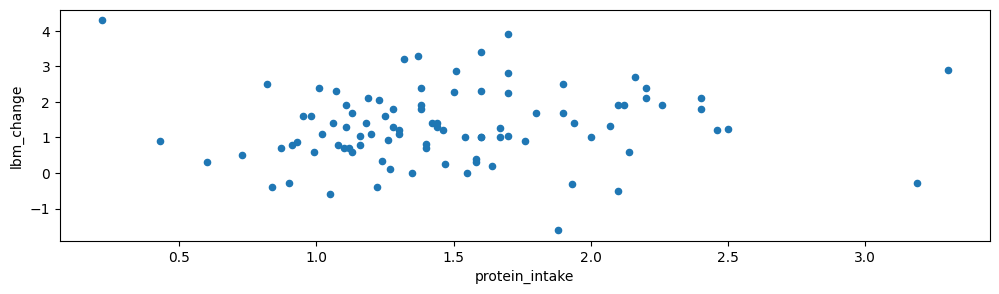

In [ ]:
data_cleaned.plot(x="protein_intake", y="lbm_change", figsize=(12, 3), kind="scatter")
#bmi vs lbmchange
#enrgyintake vs lbmchange

This doesn't appear to have much of a correlation so I'm going to try energy intake versus lean body mass change.

<Axes: xlabel='energy_intake', ylabel='lbm_change'>

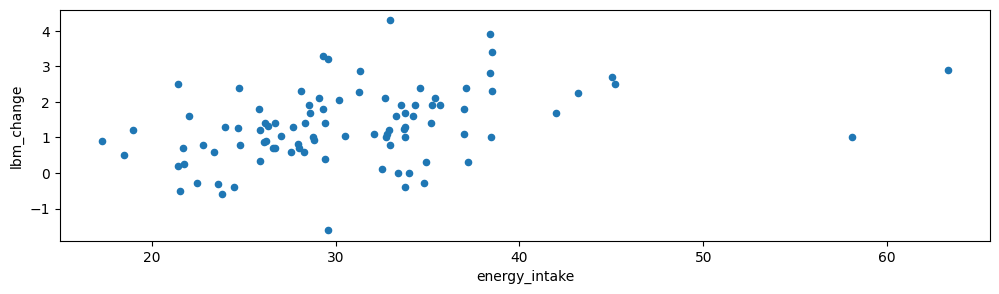

In [ ]:
data_cleaned.plot(x="energy_intake", y="lbm_change", figsize=(12, 3), kind="scatter")
#bmi vs lbmchange
#enrgyintake vs lbmchange

This has more of a correlation so I'm going to model energy intake vs relative lean body mass change per week with a GLM (generalized linear model) given that it looks pretty linear. I'm choosing a linear model over bsplines or polynomial regressions because this data is not curvy, so those would not be appropriate.


Relative lean body mass change per week is the change in lean body mass (fat free mass including bones, muscle mass and organs) (kg) divided by the duration of the experiment in weeks and the weight of the person (kg).

This model below has no interactions or other predictors. It's simply relative LBM change per week in relation to energy intake.

In [ ]:
#define the model
model1 = bmb.Model("lbm_change ~ energy_intake", data=data_cleaned)
#fit the model
idata_model1 = model1.fit(idata_kwargs={'log_likelihood': True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


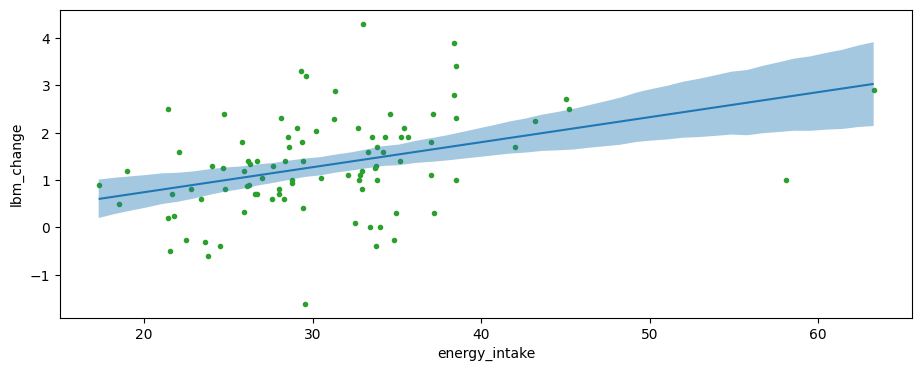

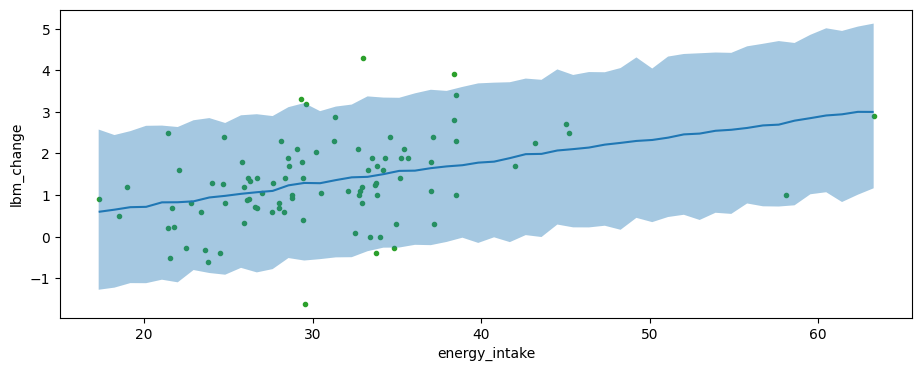

In [ ]:
#plotting
#posterior mean and posterior predictive
bmb.interpret.plot_predictions(model1, idata_model1, ["energy_intake"], fig_kwargs={"figsize":(11, 4)})
plt.plot(data_cleaned.energy_intake, data_cleaned.lbm_change, "C2.", zorder=-3)

bmb.interpret.plot_predictions(model1, idata_model1, ["energy_intake"], fig_kwargs={"figsize":(11, 4)}, pps = True)
plt.plot(data_cleaned.energy_intake, data_cleaned.lbm_change, "C2.", zorder=-3)

In [ ]:
#define the model
model2 = bmb.Model("lbm_change ~ energy_intake + energy_intake:protein_intake", data=data_cleaned)
#fit the model
idata_model2 = model2.fit(idata_kwargs={'log_likelihood': True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


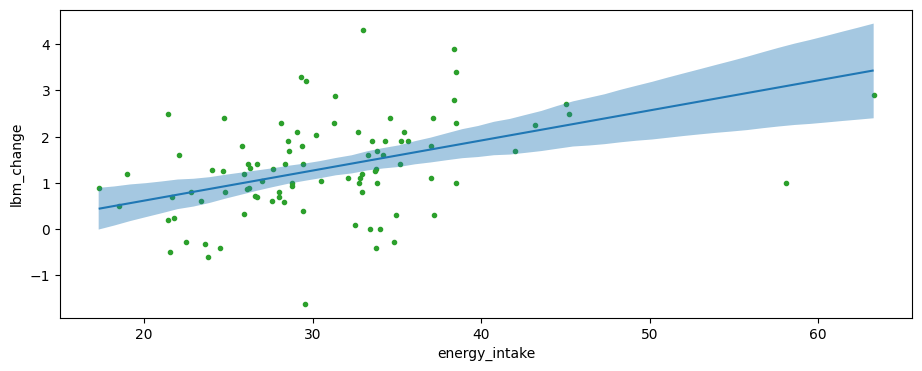

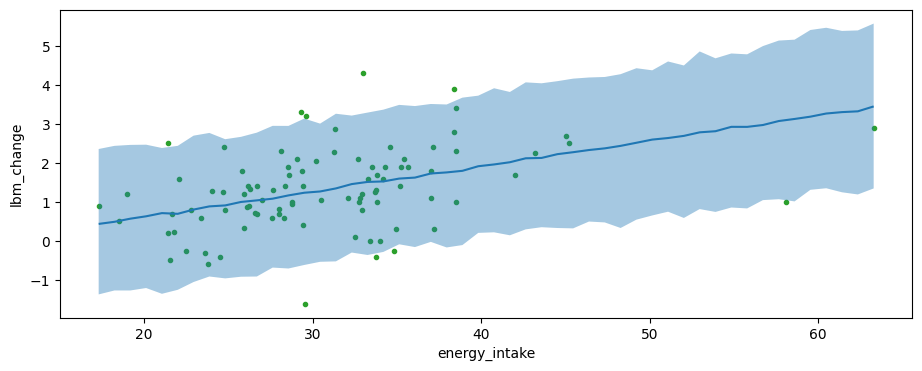

In [ ]:
#plotting
#posterior mean and posterior predictive
bmb.interpret.plot_predictions(model2, idata_model2, ["energy_intake"], fig_kwargs={"figsize":(11, 4)})
plt.plot(data_cleaned.energy_intake, data_cleaned.lbm_change, "C2.", zorder=-3)

bmb.interpret.plot_predictions(model2, idata_model2, ["energy_intake"], fig_kwargs={"figsize":(11, 4)}, pps = True)
plt.plot(data_cleaned.energy_intake, data_cleaned.lbm_change, "C2.", zorder=-3)

In [ ]:
#define the model
model3 = bmb.Model("lbm_change ~ energy_intake + age + bmi + freq + duration", data=data_cleaned)
#fit the model
idata_model3 = model3.fit(idata_kwargs={'log_likelihood': True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


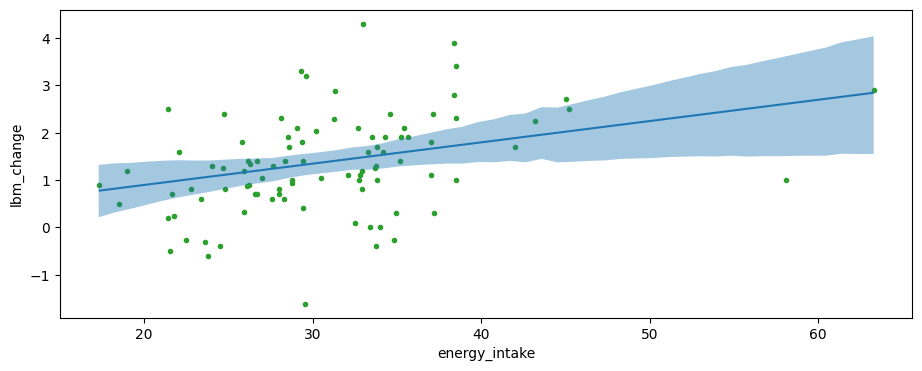

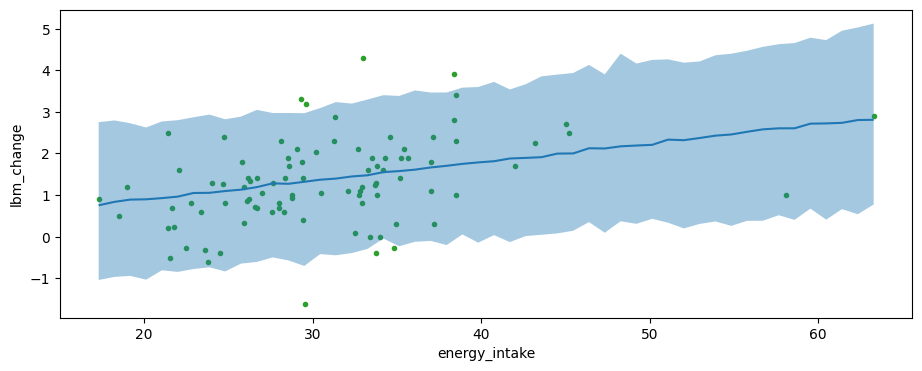

In [ ]:
#plotting
#posterior mean and posterior predictive
bmb.interpret.plot_predictions(model3, idata_model3, ["energy_intake"], fig_kwargs={"figsize":(11, 4)})
plt.plot(data_cleaned.energy_intake, data_cleaned.lbm_change, "C2.", zorder=-3)

bmb.interpret.plot_predictions(model3, idata_model3, ["energy_intake"], fig_kwargs={"figsize":(11, 4)}, pps = True)
plt.plot(data_cleaned.energy_intake, data_cleaned.lbm_change, "C2.", zorder=-3)

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

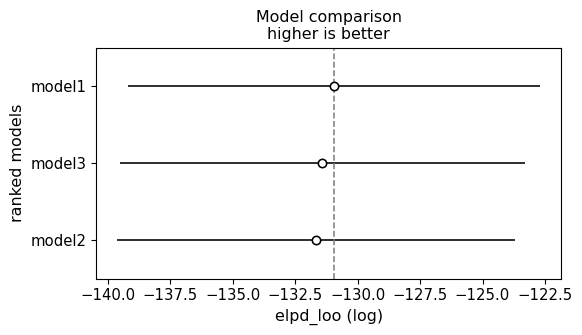

In [ ]:
loo_1 = az.loo(idata_model1)
loo_2 = az.loo(idata_model2)
loo_3 = az.loo(idata_model3)

cmp_df = az.compare({"model1":idata_model1, "model2":idata_model2, "model3":idata_model3})
cmp_df
az.plot_compare(cmp_df)

Since these models are all very similar in terms of their elpd_loo but model1 is actually the simplest I'm going to go with that one to also avoid risks of overfitting.

To mitigate overfitting (where the model is trained too well to the data and it might even capture random, unnecessary trends), you want to have a model with the smallest number of variables. Weakly informative priors also do a lot to prevent overfitting. Overall, you want to trend towards simpler models.

Thus, my best model is the GLM of energy intake versus change in lean body  mass. It suggests that higher energy intakes over a period of exercising correlates to a bigger gain in lean body mass (essentially accounts for the fat free mass).